In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from gpalib.preprocessing import preprocess_data_for_cv
from gpalib.analysis import group_variables
from gpalib import model

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
torch.manual_seed(2)   
np.random.seed(42)

RANDOM_SEED = 42
LOCAL = True

use_cuda = False
device = 'cpu'

In [4]:
if LOCAL:
    # If working in local environment
    data = pd.read_csv('../data/russia-16-19-v2.5.csv')
    print(data.shape)
    data.head()
else:     
    # If working in Google Colab
    os.mkdir('gpalib')
    os.mkdir('model')

    os.rename("__init__.py", "gpalib/__init__.py")
    os.rename("analysis.py", "gpalib/analysis.py")
    os.rename("model.py", "gpalib/model.py")
    os.rename("preprocessing.py", "gpalib/preprocessing.py")
        
    # Active CUDE in Google Colab
    use_cuda = True
    device = 'cuda'

    data = pd.read_csv('russia-16-19-v2.5.csv')
    print(data.shape)
    data.head()

(308257, 187)


In [5]:
# Splitting data in train and validation in proportion 4:1
valid_data = data.sample(frac=0.2, random_state=RANDOM_SEED)
train_data = data.drop(valid_data.index, axis=0)

In [6]:
# Data preprocessing
num_var01, num_var, cat_bin_var, cat_var = group_variables(train_data)
X_train, y_train = preprocess_data_for_cv(train_data, num_var, cat_bin_var, cat_var, train=True, prefix='nn')
X_val, y_val = preprocess_data_for_cv(valid_data, num_var, cat_bin_var, cat_var, train=False, prefix='nn')

In [7]:
INPUT_SIZE = X_train.shape[1]

### Подгрузка данных

In [8]:
class ProcurementDataset(Dataset):
    def __init__(self):
        self.len = train_data.shape[0]
        self.x_data = torch.from_numpy(X_train.astype(np.float32))
        self.y_data = torch.from_numpy(y_train)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [9]:
BATCH_SIZE = 5000
dataset = ProcurementDataset()
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(INPUT_SIZE, 60)
        self.l2 = torch.nn.Linear(60, 60)
        self.l3 = torch.nn.Linear(60, 60)
        self.l4 = torch.nn.Linear(60, 60)
        self.l5 = torch.nn.Linear(60, 2)
    
    def forward(self, x):
        out1 = F.relu(self.l1(x))
        out2 = F.relu(self.l2(out1))
        out3 = F.relu(self.l3(out2))
        out4 = F.relu(self.l4(out3))
        return self.l5(out4)

In [11]:
class Model2(torch.nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.l1 = torch.nn.Linear(INPUT_SIZE, 60)
        self.l2 = torch.nn.Linear(60, 60)
        self.l3 = torch.nn.Linear(60, 60)
        self.l4 = torch.nn.Linear(60, 60)
        self.l5 = torch.nn.Linear(60, 2)
    
    def forward(self, x):
        out1 = torch.tanh(self.l1(x))
        out2 = torch.tanh(self.l2(out1))
        out3 = torch.tanh(self.l3(out2))
        out4 = torch.tanh(self.l4(out3))
        return self.l5(out4)

In [12]:
class Model3(torch.nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.l1 = torch.nn.Linear(INPUT_SIZE, 60)
        self.dp1 = torch.nn.Dropout(p=0.5)
        self.l2 = torch.nn.Linear(60, 60)
        self.dp2 = torch.nn.Dropout(p=0.5)
        self.l3 = torch.nn.Linear(60, 60)
        self.dp3 = torch.nn.Dropout(p=0.5)
        self.l4 = torch.nn.Linear(60, 60)
        self.dp4 = torch.nn.Dropout(p=0.5)
        self.l5 = torch.nn.Linear(60, 2)
    
    def forward(self, x):
        out1 = torch.tanh(self.l1(x))
        out1 = self.dp1(out1)
        out2 = torch.tanh(self.l2(out1))
        out2 = self.dp2(out2)
        out3 = torch.tanh(self.l3(out2))
        out3 = self.dp3(out3)                          
        out4 = torch.tanh(self.l4(out3))
        out4 = self.dp4(out4)
        return self.l5(out4)

In [13]:
class Model4(torch.nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.l1 = torch.nn.Linear(INPUT_SIZE, 150)
        self.dp1 = torch.nn.Dropout(p=0.5)
        self.l2 = torch.nn.Linear(150, 150)
        self.dp2 = torch.nn.Dropout(p=0.5)
        self.l3 = torch.nn.Linear(150, 150)
        self.dp3 = torch.nn.Dropout(p=0.5)
        self.l4 = torch.nn.Linear(150, 2)
    
    def forward(self, x):
        out1 = torch.tanh(self.l1(x))
        out1 = self.dp1(out1)
        out2 = torch.tanh(self.l2(out1))
        out2 = self.dp2(out2)
        out3 = torch.tanh(self.l3(out2))
        out3 = self.dp3(out3)                          
        return self.l4(out3)

In [14]:
class Model5(torch.nn.Module):
    def __init__(self):
        super(Model5, self).__init__()
        self.l1 = torch.nn.Linear(INPUT_SIZE, 150)
        self.dp1 = torch.nn.Dropout(p=0.5)
        self.l2 = torch.nn.Linear(150, 150)
        self.dp2 = torch.nn.Dropout(p=0.5)
        self.l3 = torch.nn.Linear(150, 150)
        self.dp3 = torch.nn.Dropout(p=0.5)
        self.l4 = torch.nn.Linear(150, 150)
        self.dp4 = torch.nn.Dropout(p=0.5)
        self.l5 = torch.nn.Linear(150, 2)
    
    def forward(self, x):
        out1 = torch.tanh(self.l1(x))
        out1 = self.dp1(out1)
        out2 = torch.tanh(self.l2(out1))
        out2 = self.dp2(out2)
        out3 = torch.tanh(self.l3(out2))
        out3 = self.dp3(out3)                          
        out4 = torch.tanh(self.l4(out3))
        out4 = self.dp4(out4)
        return self.l5(out4)

In [15]:
class Model6(torch.nn.Module):
    def __init__(self):
        super(Model6, self).__init__()
        self.l1 = torch.nn.Linear(INPUT_SIZE, 150)
        self.dp1 = torch.nn.Dropout(p=0.5)
        self.l2 = torch.nn.Linear(150, 150)
        self.dp2 = torch.nn.Dropout(p=0.5)
        self.l3 = torch.nn.Linear(150, 100)
        self.dp3 = torch.nn.Dropout(p=0.5)
        self.l4 = torch.nn.Linear(100, 50)
        self.dp4 = torch.nn.Dropout(p=0.5)
        self.l5 = torch.nn.Linear(50, 2)
    
    def forward(self, x):
        out1 = torch.tanh(self.l1(x))
        out1 = self.dp1(out1)
        out2 = torch.tanh(self.l2(out1))
        out2 = self.dp2(out2)
        out3 = torch.tanh(self.l3(out2))
        out3 = self.dp3(out3)                          
        out4 = torch.tanh(self.l4(out3))
        out4 = self.dp4(out4)
        return self.l5(out4)

In [16]:
classifiers = [
    model.Classifier(Model(), 'NN1-4-60-RELU', '4-60-R', 'NN1'),
    model.Classifier(Model2(), 'NN2-4-60-TANH', '4-60-T', 'NN2'),
    model.Classifier(Model3(), 'NN3-4-60-TANH-DP', '4-60-T-DP', 'NN3'),
    model.Classifier(Model4(), 'NN4-3-150-TANH-DP', '3-150-T-DP', 'NN4'),
    model.Classifier(Model5(), 'NN5-5-150-TANH-DP', '5-150-T-DP', 'NN5'),
    model.Classifier(Model6(), 'NN6-5-150_100-TANH-DP', '5-150_100-T-DP', 'NN5')
]

In [17]:
for clf in classifiers:
    if use_cuda and torch.cuda.is_available():
        clf.clf.to(device)

In [18]:
criterion = torch.nn.CrossEntropyLoss()

In [19]:
def train(clf, num_of_epochs, optimizer, silent=False):
    """Training function"""
    
    for epoch in range(num_of_epochs):
        for batch_idx, (x_data, y_data) in enumerate(train_loader):
            x_data, labels = Variable(x_data.float()), Variable(y_data)
            
            x_data = x_data.to(device)
            labels = labels.to(device)
            
            y_pred = clf.clf(x_data)
            
            loss = criterion(y_pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_pred_proba = F.softmax(y_pred, dim=1)
            clf.y_train_real = labels
            
            if device == 'cuda':
                clf.y_train_pred = torch.argmax(y_pred_proba, dim=1).detach().cpu().numpy()
                clf.y_train_pred_proba = y_pred_proba.detach().cpu().numpy()
            else:
                clf.y_train_pred = torch.argmax(y_pred_proba, dim=1).detach().numpy()
                clf.y_train_pred_proba = y_pred_proba.detach().numpy()
            
            if not silent:
                if batch_idx % 10 == 0:
                    print('{}, train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        clf.name,
                        epoch, 
                        batch_idx * len(x_data), 
                        len(train_loader.dataset), 
                        100. * batch_idx / len(train_loader), 
                        loss.item()))

In [20]:
%%time
for clf in classifiers:
    train(clf, 10, torch.optim.Adam(clf.clf.parameters(), lr=0.01), silent=True)
    torch.save(clf.clf.state_dict(), 'model/{}_mdl.pth'.format(clf.name))
    print('Training of %s is finished' % clf.name)

# Reading model from saved state    
# for clf in classifiers:
#     clf.clf.load_state_dict(torch.load('model/{}_mdl.pth'.format(clf.name)))

Training of NN1-4-60-RELU is finished
Training of NN2-4-60-TANH is finished
Training of NN3-4-60-TANH-DP is finished
Training of NN4-3-150-TANH-DP is finished
Training of NN5-5-150-TANH-DP is finished
Training of NN6-5-150_100-TANH-DP is finished
CPU times: user 16min 22s, sys: 3min 13s, total: 19min 36s
Wall time: 9min 11s


In [21]:
x_val = torch.from_numpy(X_val.astype(np.float32))
if device == 'cuda':
    x_val = x_val.to(device)

for idx, clf in enumerate(classifiers):
    clf.clf = clf.clf.eval()
    
    y_pred_proba = F.softmax(clf.clf(Variable(x_val)), dim=1)
    
    clf.y_test_real = y_val
    
    if device == 'cuda':
        clf.y_test_pred = torch.argmax(y_pred_proba, dim=1).detach().cpu().numpy()
        clf.y_test_pred_proba = y_pred_proba.detach().cpu().numpy()
    else:
        clf.y_test_pred = torch.argmax(y_pred_proba, dim=1).detach().numpy()
        clf.y_test_pred_proba = y_pred_proba.detach().numpy()

    print('ACC:  %.3f, ROC AUC:  %.3f, log loss:  %.3f (%s)' % (
        accuracy_score(clf.y_test_real, clf.y_test_pred),
        roc_auc_score(clf.y_test_real, clf.y_test_pred_proba[:,1]),
        log_loss(clf.y_test_real, clf.y_test_pred_proba[:,1]),
        clf.name
    ))

/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ACC:  0.899, ROC AUC:  0.956, log loss:  nan (NN1-4-60-RELU)
ACC:  0.898, ROC AUC:  0.957, log loss:  0.226 (NN2-4-60-TANH)
ACC:  0.887, ROC AUC:  0.942, log loss:  0.261 (NN3-4-60-TANH-DP)
ACC:  0.888, ROC AUC:  0.946, log loss:  0.253 (NN4-3-150-TANH-DP)
ACC:  0.892, ROC AUC:  0.946, log loss:  0.259 (NN5-5-150-TANH-DP)
ACC:  0.890, ROC AUC:  0.947, log loss:  0.253 (NN6-5-150_100-TANH-DP)


Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [22]:
model.custom_classification_report(classifiers)

,4-60-R,4-60-T,4-60-T-DP,3-150-T-DP,5-150-T-DP,5-150_100-T-DP
precision_0,0.931,0.922,0.917,0.935,0.915,0.925
precision_1,0.798,0.815,0.787,0.756,0.810,0.782
recall_0,0.935,0.945,0.935,0.916,0.945,0.931
recall_1,0.786,0.755,0.740,0.802,0.729,0.766
f_score,0.792,0.784,0.762,0.778,0.767,0.774
accuracy,0.899,0.898,0.887,0.888,0.892,0.890


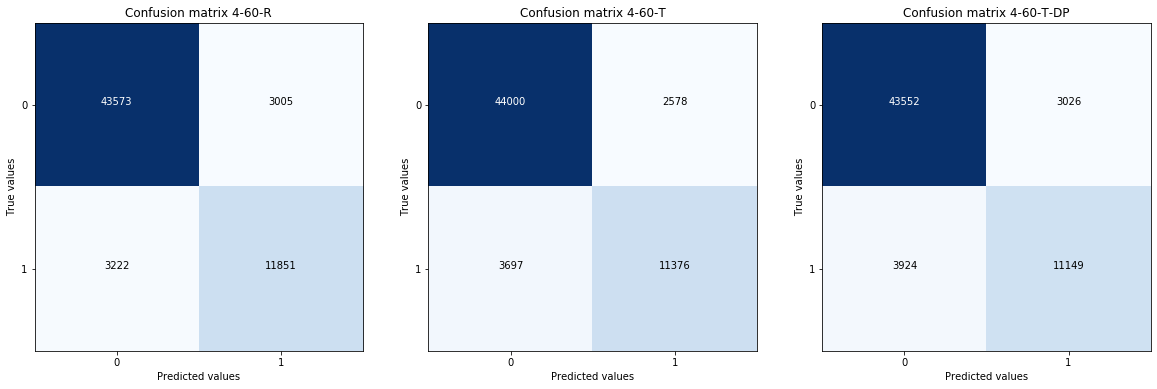

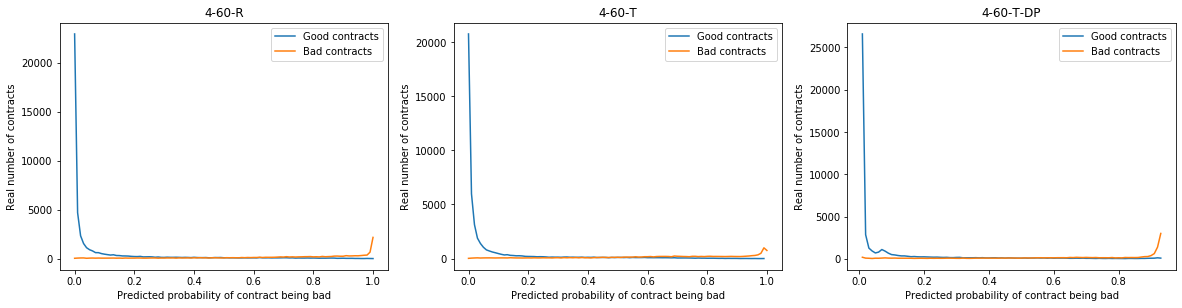

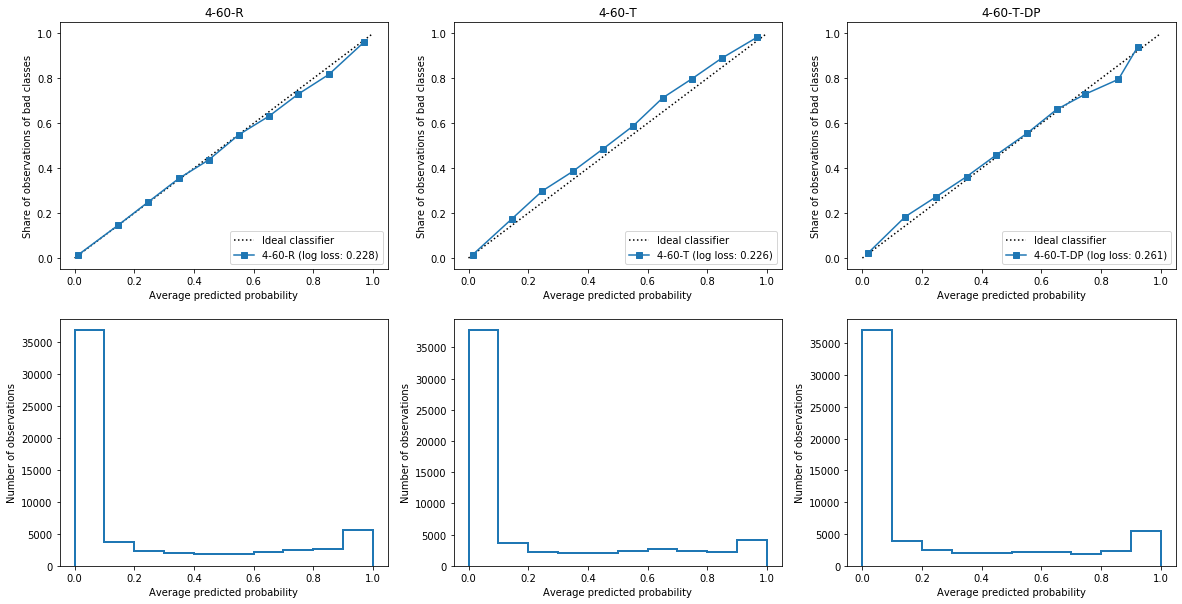

In [23]:
model.visualize_clfs_quality(classifiers[:3])

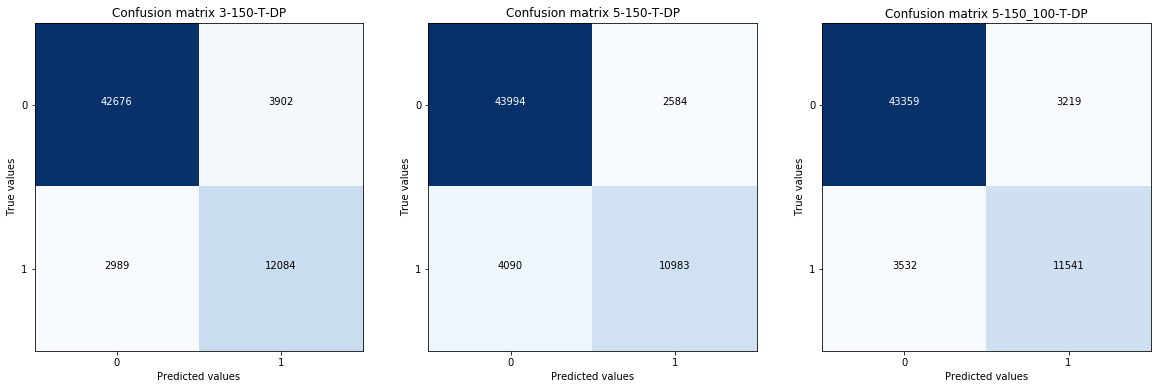

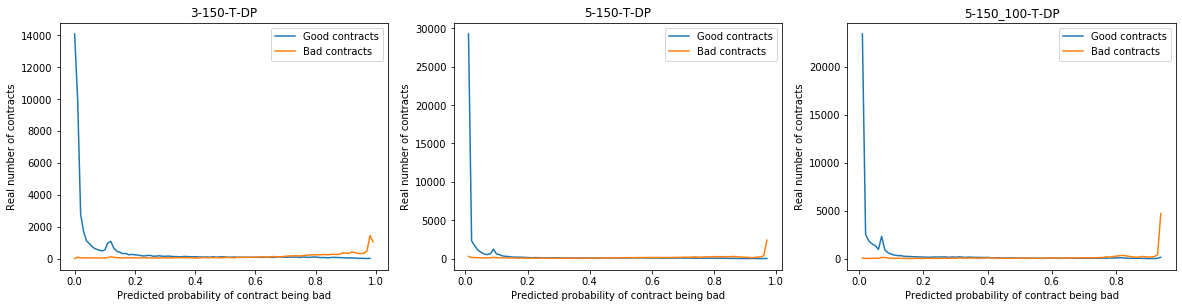

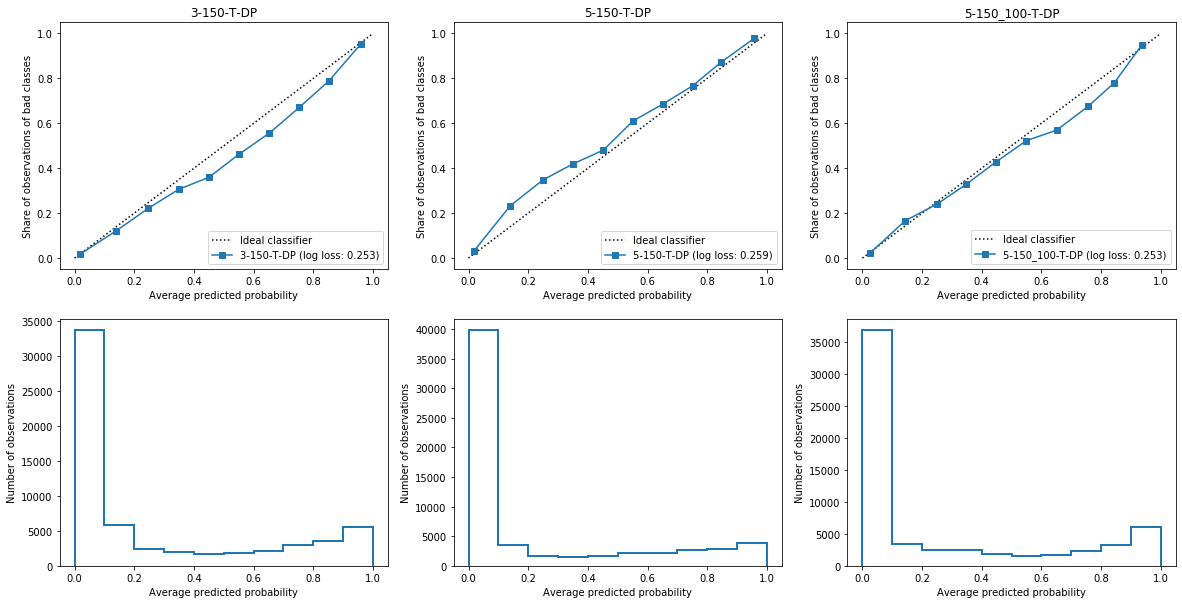

In [24]:
model.visualize_clfs_quality(classifiers[3:])

### Tutorials
**Intro in PyTorch:**
- https://habr.com/ru/company/piter/blog/354912/
- https://habr.com/ru/post/334380/
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
- https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
- https://pytorch.org/tutorials/beginner/nn_tutorial.html
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**DataLoaders:**
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

**Building model:**
- https://github.com/yhuag/neural-network-lab/blob/master/Feedforward%20Neural%20Network.ipynb
- https://colab.research.google.com/drive/1gJAAN3UI9005ecVmxPun5ZLCGu4YBtLo#scrollTo=9QAuxIQvoSDV